In [117]:
import pandas as pd

url1 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/KenPom.csv'
url2 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/RegularSeasonDetailedResults.csv'
url3 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/Teams.csv'
url4 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/TourneyCompactResults.csv'
url5 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/TourneyDetailedResults.csv'
url6 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/Team_Lookup.csv'
url7 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/RegularSeasonCompactResults.csv'
url8 = 'https://raw.github.com/WesleyPasfield/March_Madness/master/Stage_1.csv'
kp = pd.read_csv(url1)
regSeason = pd.read_csv(url2)
teams = pd.read_csv(url3)
tourneyResults = pd.read_csv(url4)
tourneyDetail = pd.read_csv(url5)
teamLookup = pd.read_csv(url6)
regSeasonComp = pd.read_csv(url7)
stage1 = pd.read_csv(url8)

allDetail = pd.concat([regSeason, tourneyDetail])


In [118]:
allDetail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66719 entries, 0 to 846
Data columns (total 38 columns):
Season       66719 non-null int64
Daynum       66719 non-null int64
Wteam        66719 non-null int64
Wscore       66719 non-null int64
Lteam        66719 non-null int64
Lscore       66719 non-null int64
Wloc         66719 non-null object
Numot        66719 non-null int64
Wfgm         66719 non-null int64
Wfga         66719 non-null int64
Wfgm3        66719 non-null int64
Wfga3        66719 non-null int64
Wftm         66719 non-null int64
Wfta         66719 non-null int64
Wor          66719 non-null int64
Wdr          66719 non-null int64
Wast         66719 non-null int64
Wto          66719 non-null int64
Wstl         66719 non-null int64
Wblk         66719 non-null int64
Wpf          66719 non-null int64
Lfgm         66719 non-null int64
Lfga         66719 non-null int64
Lfgm3        66719 non-null int64
Lfga3        66719 non-null int64
Lftm         66719 non-null int64
Lfta    

In [119]:
## Drop headers that exist in kp CSV file

kp = kp.dropna(subset = ['Pyth_NCSOS'])

## Replace seeds from team name

kp['Team'] = kp['Team'].str.replace(' 16', '')
kp['Team'] = kp['Team'].str.replace(' 15', '')
kp['Team'] = kp['Team'].str.replace(' 14', '')
kp['Team'] = kp['Team'].str.replace(' 13', '')
kp['Team'] = kp['Team'].str.replace(' 12', '')
kp['Team'] = kp['Team'].str.replace(' 11', '')
kp['Team'] = kp['Team'].str.replace(' 10', '')
kp['Team'] = kp['Team'].str.replace(' 9', '')
kp['Team'] = kp['Team'].str.replace(' 8', '')
kp['Team'] = kp['Team'].str.replace(' 7', '')
kp['Team'] = kp['Team'].str.replace(' 6', '')
kp['Team'] = kp['Team'].str.replace(' 5', '')
kp['Team'] = kp['Team'].str.replace(' 4', '')
kp['Team'] = kp['Team'].str.replace(' 3', '')
kp['Team'] = kp['Team'].str.replace(' 2', '')
kp['Team'] = kp['Team'].str.replace(' 1', '')

## Change column names for team lookup, then merge to match KP names & Kaggle Names

teamLookup.columns = ['Team', 'Team_Name']
kp2 = kp.merge(teamLookup, on = 'Team', how = 'left')

## Drop Null cases (Winston Salem St. , irrelevant), & Merge with Teams to get team_ids

kp2['nullCheck'] = pd.isnull(kp2['Team_Name'])
kp2= kp2[kp2.nullCheck != True]
kp3 = kp2.merge(teams, on = 'Team_Name', how = 'left')

## Convert variables to correct format & drop irrelevant variables

kp3[['Pyth','AdjO','AdjD','AdjT','Luck']] = kp3[['Pyth','AdjO','AdjD','AdjT','Luck']].astype(float)
kp3.drop(['Rank','Team','Conf','nullCheck','Team_Name'],inplace=True,axis=1,errors='ignore')

## Add in total adjusted team efficiency (adjO - adjD) & create variable for Team_Year

kp3['AdjT'] = kp3['AdjO'] - kp3['AdjD']
kp3['Team_Year'] = kp3.Year.map(str) + "_" + kp3.Team_Id.map(str)
kp3 = kp3[kp3['Year'] != 2002]

## Drop Unnecessary Variables

kp3.drop(['Year', 'Team_Id'], inplace=True, axis=1, errors='ignore')

## Create z score for all variables

cols = list(kp3.columns)
cols.remove('Team_Year')

for col in cols:
    col_zscore = col + '_zscore'
    kp3[col_zscore] = (kp3[col] - kp3[col].mean())/kp3[col].std(ddof=0)
    
## Pull out only z score tranformed variables
kpFin = kp3[kp3.columns[9:19]]
kpFin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 327 to 4746
Data columns (total 10 columns):
Team_Year            4420 non-null object
Pyth_zscore          4420 non-null float64
AdjO_zscore          4420 non-null float64
AdjD_zscore          4420 non-null float64
AdjT_zscore          4420 non-null float64
Luck_zscore          4420 non-null float64
Pyth_SOS_zscore      4420 non-null float64
OppO_zscore          4420 non-null float64
OppD_zscore          4420 non-null float64
Pyth_NCSOS_zscore    4420 non-null float64
dtypes: float64(9), object(1)
memory usage: 379.8+ KB


In [130]:
## Get Team_Year combinations, then create df for all game winners & losers

allDetail['W_Team_Year'] = allDetail.Season.map(str) + '_' + allDetail.Wteam.map(str)
allDetail['L_Team_Year'] = allDetail.Season.map(str) + '_' + allDetail.Lteam.map(str)
regSeasonFin= allDetail[['W_Team_Year', 'L_Team_Year', 'possW', 'possL', 'possDiff']]

## Create KP file that just has adjO, adjD, & AdjT for merging

kp4 = kp3[['Team_Year', 'AdjO','AdjD','AdjT']]

## Merge kp3 with regSeasonFin

regSeasonFin2 = regSeasonFin.merge(kp4, left_on = 'W_Team_Year', right_on = 'Team_Year')
regSeasonFin3 = regSeasonFin2.merge(kp4, left_on = 'L_Team_Year', right_on = 'Team_Year')
regSeasonFin3.columns = ['W_Team_Year', 'L_Team_Year', 'possW', 'possL', 
                         'possDiff', 'W_Team_Year2','W_AdjO','W_AdjD','W_AdjT',
                        'L_Team_Year2', 'L_AdjO', 'L_AdjD', 'L_AdjT']

regSeasonFin4 = regSeasonFin3
regSeasonFin4['W_expO'] = (regSeasonFin3['W_AdjO'] + regSeasonFin3['L_AdjD']) / 2
regSeasonFin4['W_expD'] = (regSeasonFin3['W_AdjD'] + regSeasonFin3['L_AdjO']) / 2
regSeasonFin4['L_expO'] = (regSeasonFin3['L_AdjO'] + regSeasonFin3['W_AdjD']) / 2
regSeasonFin4['L_expD'] = (regSeasonFin3['L_AdjD'] + regSeasonFin3['W_AdjO']) / 2
regSeasonFin4['expF'] = regSeasonFin3['W_AdjT'] - regSeasonFin3['L_AdjT']
regSeasonFin4['W_ActO_ExpO'] = regSeasonFin4['possW'] - regSeasonFin4['W_expO']
regSeasonFin4['W_ActD_ExpD'] = regSeasonFin4['possL'] - regSeasonFin4['W_expD']
regSeasonFin4['L_ActO_ExpO'] = regSeasonFin4['possL'] - regSeasonFin4['L_expO']
regSeasonFin4['L_ActD_ExpD'] = regSeasonFin4['possW'] - regSeasonFin4['L_expD']
regSeasonFin4['ActF-ExpF'] = regSeasonFin4['possDiff'] - regSeasonFin4['expF']
regSeasonFin4['W_ActO_ExpO_Abs'] = abs(regSeasonFin4['possW'] - regSeasonFin4['W_expO'])
regSeasonFin4['W_ActD_ExpD_Abs'] = abs(regSeasonFin4['possL'] - regSeasonFin4['W_expD'])
regSeasonFin4['L_ActO_ExpO_Abs'] = abs(regSeasonFin4['possL'] - regSeasonFin4['L_expO'])
regSeasonFin4['L_ActD_ExpD_Abs'] = abs(regSeasonFin4['possW'] - regSeasonFin4['L_expD'])
regSeasonFin4['ActF-ExpF_Abs'] = abs(regSeasonFin4['possDiff'] - regSeasonFin4['expF'])

regSeasLoss = regSeasonFin4[['L_Team_Year','L_ActO_ExpO', 'L_ActO_ExpO_Abs', 
                             'L_ActD_ExpD','L_ActD_ExpD_Abs','ActF-ExpF','ActF-ExpF_Abs']]
                                                            
regSeasWin = regSeasonFin4[['W_Team_Year','W_ActO_ExpO', 'W_ActO_ExpO_Abs', 'W_ActD_ExpD',
                             'W_ActD_ExpD_Abs', 'ActF-ExpF', 'ActF-ExpF_Abs']]

regSeasLoss.columns = ['Team_Year', 'AdjO_Vol', 'AdjO_Vol_Abs', 'AdjD_Vol', 'AdjD_Vol_Abs', 'AdjT_Vol', 'AdjT_Vol_Abs']
regSeasWin.columns = ['Team_Year', 'AdjO_Vol', 'AdjO_Vol_Abs', 'AdjD_Vol', 'AdjD_Vol_Abs', 'AdjT_Vol', 'AdjT_Vol_Abs']

regSeasConcat = pd.concat([regSeasLoss, regSeasWin])
regSeasGroupAverage = regSeasConcat.groupby(['Team_Year']).mean()
regSeasGroupAverage['Team_Year'] = regSeasGroupAverage.index
regSeasGroupAverage = regSeasGroupAverage[['Team_Year', 'AdjO_Vol_Abs', 'AdjD_Vol_Abs', 'AdjT_Vol_Abs']]
regSeasGroupAverage.columns = ['Team_Year', 'AdjO_Vol_Avg', 'AdjD_Vol_Avg', 'AdjT_Vol_Avg']

regSeasGroupMax = regSeasConcat.groupby(['Team_Year']).max()
regSeasGroupMax['Team_Year'] = regSeasGroupMax.index
regSeasGroupMax = regSeasGroupMax[['Team_Year', 'AdjO_Vol' ,'AdjD_Vol', 'AdjT_Vol']]
regSeasGroupMax.columns = ['Team_Year', 'AdjO_Vol_Max' ,'AdjD_Vol_Max', 'AdjT_Vol_Max']

regSeasGroupMin = regSeasConcat.groupby(['Team_Year']).min()
regSeasGroupMin['Team_Year'] = regSeasGroupMin.index
regSeasGroupMin = regSeasGroupMin[['Team_Year', 'AdjO_Vol' ,'AdjD_Vol', 'AdjT_Vol']]
regSeasGroupMin.columns = ['Team_Year', 'AdjO_Vol_Min' ,'AdjD_Vol_Min', 'AdjT_Vol_Min']

regSeasGroupMaxMin = regSeasGroupMax.merge(regSeasGroupMin, on = 'Team_Year')
regSeasGroupMaxMin['AdjO_Vol_Range'] = regSeasGroupMaxMin['AdjO_Vol_Max'] - regSeasGroupMaxMin['AdjO_Vol_Min']
regSeasGroupMaxMin['AdjD_Vol_Range'] = regSeasGroupMaxMin['AdjD_Vol_Max'] - regSeasGroupMaxMin['AdjD_Vol_Min']
regSeasGroupMaxMin['AdjT_Vol_Range'] = regSeasGroupMaxMin['AdjT_Vol_Max'] - regSeasGroupMaxMin['AdjT_Vol_Min']
regSeasGroupFin = regSeasGroupMaxMin.merge(regSeasGroupAverage, on = 'Team_Year')
regSeasGroupFin.index = regSeasGroupFin['Team_Year']
regSeasGroupFin.head(n =10)

## Create z score for all variables

cols = list(regSeasGroupFin.columns)
cols.remove('Team_Year')

for col in cols:
    col_zscore = col + '_zscore'
    regSeasGroupFin[col_zscore] = (regSeasGroupFin[col] - regSeasGroupFin[col].mean())/regSeasGroupFin[col].std(ddof=0)
    
regSeasMerge = regSeasGroupFin[['Team_Year', 'AdjO_Vol_Max_zscore', 'AdjD_Vol_Max_zscore',
                               'AdjT_Vol_Max_zscore', 'AdjO_Vol_Min_zscore', 'AdjD_Vol_Min_zscore',
                               'AdjT_Vol_Min_zscore', 'AdjO_Vol_Range_zscore', 'AdjD_Vol_Range_zscore',
                               'AdjT_Vol_Range_zscore', 'AdjO_Vol_Avg_zscore', 'AdjD_Vol_Avg_zscore',
                               'AdjT_Vol_Avg_zscore']]


kpMerge = kpFin.merge(regSeasMerge, on = 'Team_Year', how = 'left')
kpLogData = kp3.merge(regSeasGroupFin, on = 'Team_Year', how = 'left')
kpMerge.columns

Index(['Team_Year', 'Pyth_zscore', 'AdjO_zscore', 'AdjD_zscore', 'AdjT_zscore',
       'Luck_zscore', 'Pyth_SOS_zscore', 'OppO_zscore', 'OppD_zscore',
       'Pyth_NCSOS_zscore', 'AdjO_Vol_Max_zscore', 'AdjD_Vol_Max_zscore',
       'AdjT_Vol_Max_zscore', 'AdjO_Vol_Min_zscore', 'AdjD_Vol_Min_zscore',
       'AdjT_Vol_Min_zscore', 'AdjO_Vol_Range_zscore', 'AdjD_Vol_Range_zscore',
       'AdjT_Vol_Range_zscore', 'AdjO_Vol_Avg_zscore', 'AdjD_Vol_Avg_zscore',
       'AdjT_Vol_Avg_zscore'],
      dtype='object')

In [121]:
## Take log of all variables

import math

cols = list(kpLogData.columns)
cols.remove('Team_Year')

for col in cols:
    col_log = col + '_log'
    kpLogData[col_log] = np.log(kpLogData[col])
    
## Pull out only useful log transforms 
kpLog = kpLogData[['Team_Year','AdjO_Vol_Range_log', 'AdjD_Vol_Range_log', 'AdjT_Vol_Range_log',
                  'AdjO_Vol_Avg_log', 'AdjD_Vol_Avg_log', 'AdjT_Vol_Avg_log']]
kpLog.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 0 to 4419
Data columns (total 7 columns):
Team_Year             4420 non-null object
AdjO_Vol_Range_log    4420 non-null float64
AdjD_Vol_Range_log    4420 non-null float64
AdjT_Vol_Range_log    4420 non-null float64
AdjO_Vol_Avg_log      4420 non-null float64
AdjD_Vol_Avg_log      4420 non-null float64
AdjT_Vol_Avg_log      4420 non-null float64
dtypes: float64(6), object(1)
memory usage: 276.2+ KB


In [122]:
## Take exp of all variables

cols = list(kpLogData.columns)
cols.remove('Team_Year')

for col in cols:
    col_exp = col + '_exp'
    kpLogData[col_exp] = np.exp(kpLogData[col])
    
## Pull out only useful exp tranformed variables
kpExp = kpLogData[['Team_Year', 'Pyth_NCSOS_exp', 'Luck_exp']]
kpExp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 0 to 4419
Data columns (total 3 columns):
Team_Year         4420 non-null object
Pyth_NCSOS_exp    4420 non-null float64
Luck_exp          4420 non-null float64
dtypes: float64(2), object(1)
memory usage: 138.1+ KB


In [131]:
kpTransformed = kpMerge.merge(kpExp, on = 'Team_Year', how = 'left')
kpMergeFinal = kpTransformed.merge(kpLog, on = 'Team_Year', how = 'left')
kpMergeFinal.drop(['Luck_zscore', 'Pyth_NCSOS_zscore' ,'AdjO_Vol_Avg_zscore' ,'AdjD_Vol_Avg_zscore',
                  'AdjT_Vol_Avg_zscore', 'AdjO_Vol_Range_zscore', 'AdjD_Vol_Range_zscore', 'AdjT_Vol_Range_zscore']
                 ,inplace=True,axis=1,errors='ignore')
kpMergeFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 0 to 4419
Data columns (total 22 columns):
Team_Year              4420 non-null object
Pyth_zscore            4420 non-null float64
AdjO_zscore            4420 non-null float64
AdjD_zscore            4420 non-null float64
AdjT_zscore            4420 non-null float64
Pyth_SOS_zscore        4420 non-null float64
OppO_zscore            4420 non-null float64
OppD_zscore            4420 non-null float64
AdjO_Vol_Max_zscore    4420 non-null float64
AdjD_Vol_Max_zscore    4420 non-null float64
AdjT_Vol_Max_zscore    4420 non-null float64
AdjO_Vol_Min_zscore    4420 non-null float64
AdjD_Vol_Min_zscore    4420 non-null float64
AdjT_Vol_Min_zscore    4420 non-null float64
Pyth_NCSOS_exp         4420 non-null float64
Luck_exp               4420 non-null float64
AdjO_Vol_Range_log     4420 non-null float64
AdjD_Vol_Range_log     4420 non-null float64
AdjT_Vol_Range_log     4420 non-null float64
AdjO_Vol_Avg_log       4420 non-null fl

/Users/Wesley/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


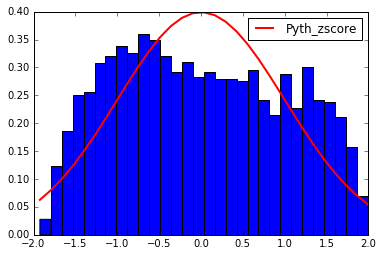

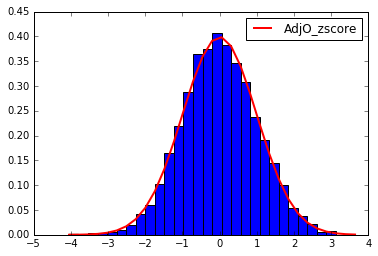

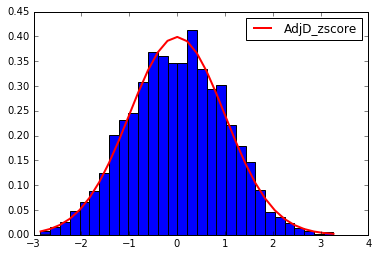

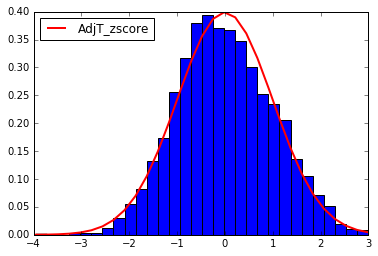

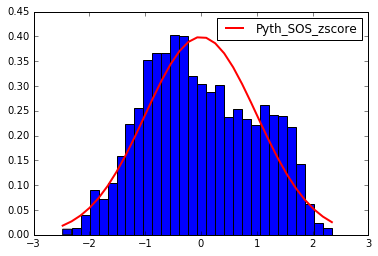

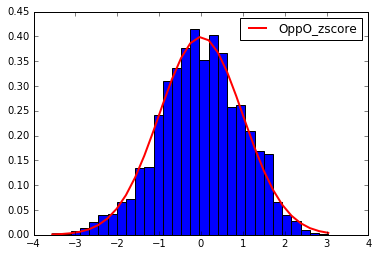

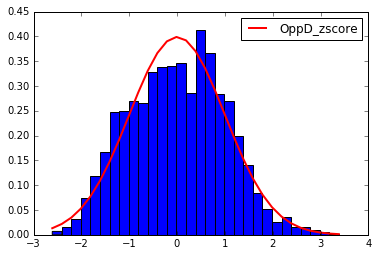

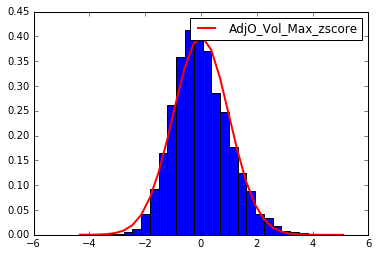

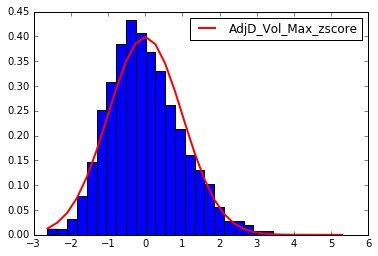

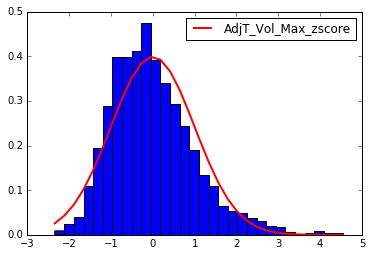

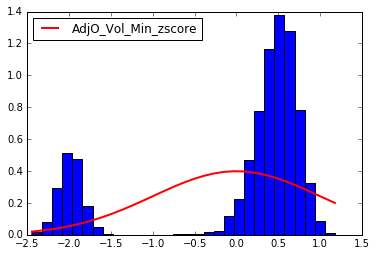

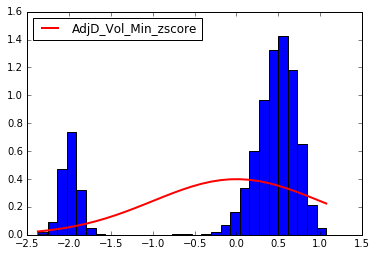

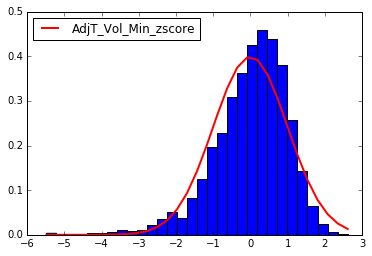

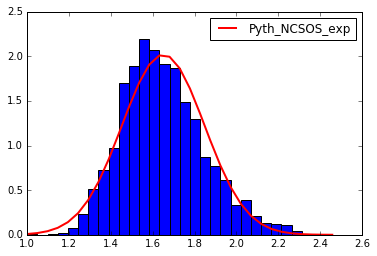

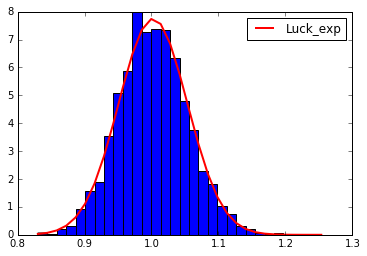

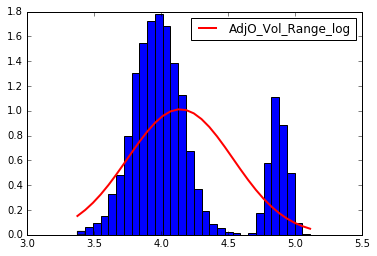

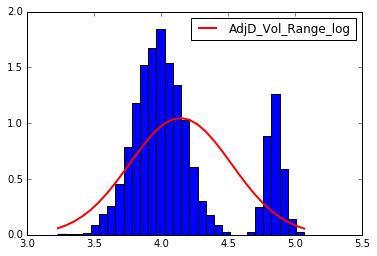

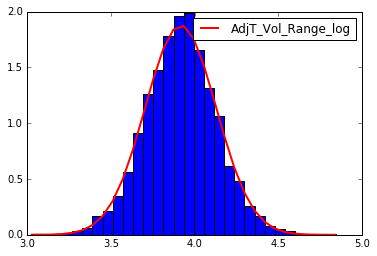

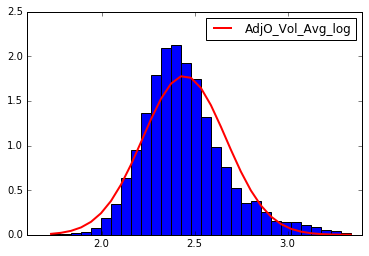

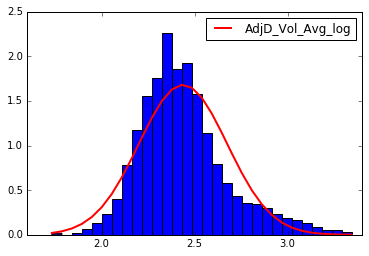

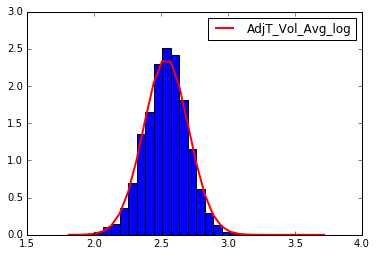

In [128]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

kpGraph2 = kpMergeFinal
kpGraph2.drop('Team_Year', axis =1, inplace = True)
kpCol = list(kpGraph2.columns)
axes = plt.gca()

for column in kpGraph2:
    s = kpGraph2[column]
    mu = np.mean(kpGraph2[column])
    sigma = np.std(kpGraph2[column])
    count, bins, ignored = plt.hist(s, 30, normed=True)
    plt.plot(bins, 1/(sigma * np.sqrt(2*np.pi)) *
       np.exp( - (bins - mu) ** 2 / (2 * sigma ** 2)),
       linewidth = 2, color = 'r', label=column)
    plt.legend(loc=0)
    plt.figure()
    
## NOTE MUST RERUN IN [130] before continuing to replace Team_Year. Need to figure out better way of 
## deleting team_year from these graphs, but not having to rerun code to replace it

In [151]:
## Model using difference between the two teams across all variables

regUse = regSeasonComp[['Wteam', 'Lteam', 'Home', 'Neutral', 'Away', 'Win']]
tourneyUse = tourneyResults[['Wteam', 'Lteam', 'Home', 'Neutral', 'Away', 'Win']]

allUse = pd.concat([regUse, tourneyUse])

kpModel = allUse.merge(kpMergeFinal, left_on = 'Wteam', right_on = 'Team_Year')
kpModel = kpModel.merge(kpMergeFinal, left_on = 'Lteam', right_on = 'Team_Year')

kpModel['Pyth_diff'] = kpModel['Pyth_zscore_x'] - kpModel['Pyth_zscore_y']
kpModel['AdjO_diff'] = kpModel['AdjO_zscore_x'] - kpModel['AdjO_zscore_y']
kpModel['AdjD_diff'] = kpModel['AdjD_zscore_x'] - kpModel['AdjD_zscore_y']
kpModel['AdjT_diff'] = kpModel['AdjT_zscore_x'] - kpModel['AdjT_zscore_y']
kpModel['Luck_diff'] = kpModel['Luck_exp_x'] - kpModel['Luck_exp_y']
kpModel['Pyth_SOS_diff'] = kpModel['Pyth_SOS_zscore_x'] - kpModel['Pyth_SOS_zscore_y']
kpModel['OppO_diff'] = kpModel['OppO_zscore_x'] - kpModel['OppO_zscore_y']
kpModel['OppD_diff'] = kpModel['OppD_zscore_x'] - kpModel['OppD_zscore_y']
kpModel['Pyth_NCSOS_diff'] = kpModel['Pyth_NCSOS_exp_x'] - kpModel['Pyth_NCSOS_exp_y']
kpModel['AdjO_Vol_Max_diff'] = kpModel['AdjO_Vol_Max_zscore_x'] - kpModel['AdjO_Vol_Max_zscore_y']
kpModel['AdjD_Vol_Max_diff'] = kpModel['AdjD_Vol_Max_zscore_x'] - kpModel['AdjD_Vol_Max_zscore_y']
kpModel['AdjT_Vol_Max_diff'] = kpModel['AdjT_Vol_Max_zscore_x'] - kpModel['AdjT_Vol_Max_zscore_y']
kpModel['AdjO_Vol_Min_diff'] = kpModel['AdjO_Vol_Min_zscore_x'] - kpModel['AdjO_Vol_Min_zscore_y']
kpModel['AdjD_Vol_Min_diff'] = kpModel['AdjD_Vol_Min_zscore_x'] - kpModel['AdjD_Vol_Min_zscore_y']
kpModel['AdjT_Vol_Min_diff'] = kpModel['AdjT_Vol_Min_zscore_x'] - kpModel['AdjT_Vol_Min_zscore_y']
kpModel['AdjO_Vol_Range_diff'] = kpModel['AdjO_Vol_Range_log_x'] - kpModel['AdjO_Vol_Range_log_y']
kpModel['AdjD_Vol_Range_diff'] = kpModel['AdjD_Vol_Range_log_x'] - kpModel['AdjD_Vol_Range_log_y']
kpModel['AdjT_Vol_Range_diff'] = kpModel['AdjT_Vol_Range_log_x'] - kpModel['AdjT_Vol_Range_log_y']
kpModel['AdjO_Vol_Avg_diff'] = kpModel['AdjO_Vol_Avg_log_x'] - kpModel['AdjO_Vol_Avg_log_y']
kpModel['AdjD_Vol_Avg_diff'] = kpModel['AdjD_Vol_Avg_log_x'] - kpModel['AdjD_Vol_Avg_log_y']
kpModel['AdjT_Vol_Avg_diff'] = kpModel['AdjT_Vol_Avg_log_x'] - kpModel['AdjT_Vol_Avg_log_y']

kpModel['id'] = kpModel.Wteam.str[:4] + '_' + kpModel.Wteam.str[4:] + '_' + kpModel.Lteam.str[4:]

kpFinal = kpModel.iloc[:,[2,3,4,5,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71]]
Target = 'Win'
IDcol = 'id'


Model Report
Accuracy: 0.7648
AUC Score (Train): 0.851204
CV Score : Mean - 0.847168 | Std - 0.003386358 | Min - 0.8429558 | Max - 0.8531251


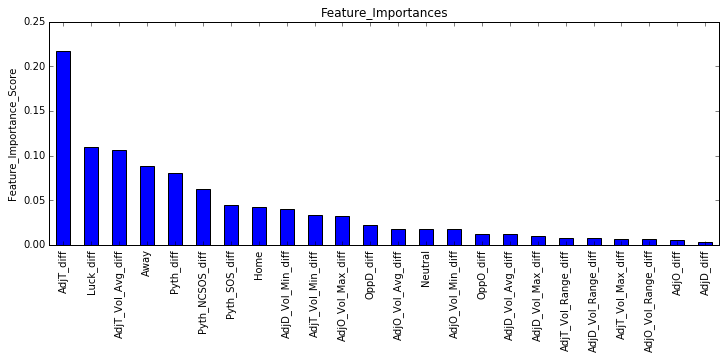

In [175]:

import sklearn.ensemble as ens
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,4

tIndex = np.random.rand(len(kpFinal)) < 0.75
X_train = kpFinal[tIndex]
X_test = kpFinal[~tIndex]

def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds =5):
    ## Fit algorithm to the data
    alg.fit(dtrain[predictors], dtrain['Win'])
    ## Predict Training Set
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob=alg.predict_proba(dtrain[predictors])[:,1]
    ## Perform Cross validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Win'], 
                                                    cv=cv_folds, scoring = 'roc_auc')
    ## Print model report
    print("\nModel Report")
    print("Accuracy: %.4g" % metrics.accuracy_score(dtrain['Win'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Win'], dtrain_predprob))
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" 
        % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
        
    ## Print Feature Importance
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature_Importances')
        plt.ylabel('Feature_Importance_Score')
        
predictors = [x for x in X_train.columns if x not in [Target, IDcol]]

param_test1 = {'n_estimators': [50, 75, 100]}
gSearch1 = GridSearchCV(estimator = ens.GradientBoostingClassifier(max_depth =5 , learning_rate = 0.1, min_samples_split = 500,
                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
                                         random_state = 10),
param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gSearch1.fit(X_train[predictors],X_train[Target])
modelfit(gSearch1, X_train, predictors)


In [ ]:
## Grid Search for number of estimators

predictors = [x for x in X_train.columns if x not in [Target, IDcol]]

param_test1 = {'n_estimators': [100, 200, 300]}
gSearch1 = GridSearchCV(estimator = ens.GradientBoostingClassifier(max_depth =5 , learning_rate = 0.1, min_samples_split = 500,
                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
                                         random_state = 10),
param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gSearch1.fit(X_train[predictors],X_train[Target])
modelfit(gSearch1, X_train, predictors)
xgSearch1.grid_scores_, gSearch1.best_params_, gSearch1.best_score_

In [ ]:
## Grid Search for learning_rate

predictors = [x for x in X_train.columns if x not in [Target, IDcol]]

param_test1 = {'learning_rate': [.05, .1, .15]}
gSearch1 = GridSearchCV(estimator = ens.GradientBoostingClassifier(max_depth =5 , n_estimators =, min_samples_split = 500,
                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
                                         random_state = 10),
param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gSearch1.fit(X_train[predictors],X_train[Target])
modelfit(gSearch1, X_train, predictors)

In [178]:
gSearch1.grid_scores_, gSearch1.best_params_, gSearch1.best_score_

([mean: 0.84553, std: 0.00307, params: {'n_estimators': 50},
  mean: 0.84680, std: 0.00328, params: {'n_estimators': 75},
  mean: 0.84730, std: 0.00323, params: {'n_estimators': 100}],
 {'n_estimators': 100},
 0.84729588312061066)

In [57]:
predictions = gbm.predict_proba(X_test)
predictions


array([[ 0.69273905,  0.30726095],
       [ 0.62813065,  0.37186935],
       [ 0.6898363 ,  0.3101637 ],
       ..., 
       [ 0.13453458,  0.86546542],
       [ 0.69809482,  0.30190518],
       [ 0.8417771 ,  0.1582229 ]])

In [61]:
import xgboost as xgb

xgb1 = xgb.XGBClassifier(max_depth =5 , learning_rate = 0.1, n_estimators = 100,
                                    subsample= .85, colsample_bytree =.85, 
                                     objective = 'binary:logistic').fit(X_train, y_train)


In [62]:
predictions = xgb1.predict_proba(X_test)
predictions

array([[ 0.68761265,  0.31238735],
       [ 0.58896637,  0.41103363],
       [ 0.67596853,  0.3240315 ],
       ..., 
       [ 0.18509209,  0.81490791],
       [ 0.70939124,  0.29060876],
       [ 0.8305701 ,  0.16942993]], dtype=float32)

In [113]:
## Test Predictor


kpModelStage1 = stage1.merge(kpMerge, left_on = 'Wteam', right_on = 'Team_Year')
kpModelStage1 = kpModelStage1.merge(kpMerge, left_on = 'Lteam', right_on = 'Team_Year')

kpModelStage1['Pyth_diff'] = kpModelStage1['Pyth_zscore_x'] - kpModelStage1['Pyth_zscore_y']
kpModelStage1['AdjO_diff'] = kpModelStage1['AdjO_zscore_x'] - kpModelStage1['AdjO_zscore_y']
kpModelStage1['AdjD_diff'] = kpModelStage1['AdjD_zscore_x'] - kpModelStage1['AdjD_zscore_y']
kpModelStage1['AdjT_diff'] = kpModelStage1['AdjT_zscore_x'] - kpModelStage1['AdjT_zscore_y']
kpModelStage1['Luck_diff'] = kpModelStage1['Luck_zscore_x'] - kpModelStage1['Luck_zscore_y']
kpModelStage1['Pyth_SOS_diff'] = kpModelStage1['Pyth_SOS_zscore_x'] - kpModelStage1['Pyth_SOS_zscore_y']
kpModelStage1['OppO_diff'] = kpModelStage1['OppO_zscore_x'] - kpModelStage1['OppO_zscore_y']
kpModelStage1['OppD_diff'] = kpModelStage1['OppD_zscore_x'] - kpModelStage1['OppD_zscore_y']
kpModelStage1['Pyth_NCSOS_diff'] = kpModelStage1['Pyth_NCSOS_zscore_x'] - kpModelStage1['Pyth_NCSOS_zscore_y']
kpModelStage1['AdjO_Vol_Max_diff'] = kpModelStage1['AdjO_Vol_Max_zscore_x'] - kpModelStage1['AdjO_Vol_Max_zscore_y']
kpModelStage1['AdjD_Vol_Max_diff'] = kpModelStage1['AdjD_Vol_Max_zscore_x'] - kpModelStage1['AdjD_Vol_Max_zscore_y']
kpModelStage1['AdjT_Vol_Max_diff'] = kpModelStage1['AdjT_Vol_Max_zscore_x'] - kpModelStage1['AdjT_Vol_Max_zscore_y']
kpModelStage1['AdjO_Vol_Min_diff'] = kpModelStage1['AdjO_Vol_Min_zscore_x'] - kpModelStage1['AdjO_Vol_Min_zscore_y']
kpModelStage1['AdjD_Vol_Min_diff'] = kpModelStage1['AdjD_Vol_Min_zscore_x'] - kpModelStage1['AdjD_Vol_Min_zscore_y']
kpModelStage1['AdjT_Vol_Min_diff'] = kpModelStage1['AdjT_Vol_Min_zscore_x'] - kpModelStage1['AdjT_Vol_Min_zscore_y']
kpModelStage1['AdjO_Vol_Range_diff'] = kpModelStage1['AdjO_Vol_Range_zscore_x'] - kpModelStage1['AdjO_Vol_Range_zscore_y']
kpModelStage1['AdjD_Vol_Range_diff'] = kpModelStage1['AdjD_Vol_Range_zscore_x'] - kpModelStage1['AdjD_Vol_Range_zscore_y']
kpModelStage1['AdjT_Vol_Range_diff'] = kpModelStage1['AdjT_Vol_Range_zscore_x'] - kpModelStage1['AdjT_Vol_Range_zscore_y']
kpModelStage1['AdjO_Vol_Avg_diff'] = kpModelStage1['AdjO_Vol_Avg_zscore_x'] - kpModelStage1['AdjO_Vol_Avg_zscore_y']
kpModelStage1['AdjD_Vol_Avg_diff'] = kpModelStage1['AdjD_Vol_Avg_zscore_x'] - kpModelStage1['AdjD_Vol_Avg_zscore_y']
kpModelStage1['AdjT_Vol_Avg_diff'] = kpModelStage1['AdjT_Vol_Avg_zscore_x'] - kpModelStage1['AdjT_Vol_Avg_zscore_y']

kpModelStage1['id'] = kpModelStage1.Wteam.str[:4] + '_' + kpModelStage1.Wteam.str[4:] + '_' + kpModelStage1.Lteam.str[4:]
kpFinalStage1 = kpModelStage1.iloc[:,[2,3,4,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69]]


In [114]:
kpFinalStage1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9112 entries, 0 to 9111
Data columns (total 24 columns):
Home                   9112 non-null int64
Neutral                9112 non-null int64
Away                   9112 non-null int64
Pyth_diff              9112 non-null float64
AdjO_diff              9112 non-null float64
AdjD_diff              9112 non-null float64
AdjT_diff              9112 non-null float64
Luck_diff              9112 non-null float64
Pyth_SOS_diff          9112 non-null float64
OppO_diff              9112 non-null float64
OppD_diff              9112 non-null float64
Pyth_NCSOS_diff        9112 non-null float64
AdjO_Vol_Max_diff      9112 non-null float64
AdjD_Vol_Max_diff      9112 non-null float64
AdjT_Vol_Max_diff      9112 non-null float64
AdjO_Vol_Min_diff      9112 non-null float64
AdjD_Vol_Min_diff      9112 non-null float64
AdjT_Vol_Min_diff      9112 non-null float64
AdjO_Vol_Range_diff    9112 non-null float64
AdjD_Vol_Range_diff    9112 non-null float64

In [118]:
import os


X_testStage1 = kpFinalStage1

predSub = gbm.predict_proba(X_testStage1)
predSub2 = xgb1.predict_proba(X_testStage1)

submission = pd.DataFrame({'id': kpModelStage1['id'],
                           'pred' : predSub[:,1]})
submission2 = pd.DataFrame({'id': kpModelStage1['id'],
                           'pred' : predSub2[:,1]})

path = '/Users/Wesley/Documents/Kaggle/MarchMadness'
os.chdir(path)

submission.to_csv('gbmSubmission.csv')
submission2.to_csv('xgbSubmission.csv')



In [95]:
from matplotlib import pylab as plt
xgb.plot_importance(xgb1)
plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

NameError: name 'df' is not defined

In [97]:
TO DO

Visualize the data
Tune the model
Work in Tourney results
Remove __ from id variable, not sure why that is happening

NameError: name 'getcwd' is not defined